# Latent Space Insights
---
This notebook explores some of the key properties of the Latent Space in the HighDimSynthesizer.

In [1]:
import os
import warnings
from typing import List
import logging
import json
import time

warnings.filterwarnings(action='ignore', module='numpy')
warnings.filterwarnings(action='ignore', module='pandas')
warnings.filterwarnings(action='ignore', module='sklearn')
warnings.filterwarnings(action='ignore', module='tensorflow')
warnings.filterwarnings(action='ignore', module='ipykernal')

from IPython.display import clear_output

import random as rd
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from synthesized import MetaExtractor
from synthesized.complex.highdim import HighDimSynthesizer, HighDimConfig
from synthesized.common.values import ValueFactory
from synthesized.insight.latent import latent_kl_difference, latent_dimension_usage, total_latent_space_usage, get_latent_space
from synthesized.insight.dataset import describe_dataset_values, describe_dataset
from synthesized.testing.utility import UtilityTesting


if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(os.path.split(workbookDir)[0])[0])

pd.options.display.max_rows = 1500

%load_ext autoreload
%autoreload 2
%matplotlib inline

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-32F3-2D31-322D-B531
Expires at: 2020-12-31 00:00:00


## Datasets - Credit Scoring
---



In [2]:
credit = pd.read_csv('data/templates/credit.csv').dropna()
credit

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149994,0,0.385742,50,0,0.404293,3400.0,7,0,0,0,0.0
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [3]:
dp = MetaExtractor.extract(credit)
config = HighDimConfig(learning_manager=False)
synth = HighDimSynthesizer(dp, config=config)

synth.learn(df_train=credit, num_iterations=10000)

In [30]:
def create_bad_data(df: pd.DataFrame, n: int):
    bad_dict = {}
    for col in df.columns:
        bad_dict[col] = df[col].sample(n).reset_index(drop=True)
    return pd.DataFrame(bad_dict)

def corrupt_data(df: pd.DataFrame, n: int, percent: float, shuffle: bool = True):
    size = n
    bad_size = int(percent*size)
    bad_df = create_bad_data(df, bad_size)
    good_df = df.sample(size-bad_size).reset_index(drop=True)
    
    if shuffle:
        return pd.concat((good_df, bad_df), axis=0, sort=False).sample(size, replace=False).reset_index(drop=True)
    else:
        return pd.concat((good_df, bad_df), axis=0, sort=False).reset_index(drop=True)

def upscale_srs_dlq(df: pd.DataFrame, percent: float, shuffle: bool = True):
    size = len(df)
    bad_size = int(percent*size)
    bad_df = df[df['SeriousDlqin2yrs']==1].sample(bad_size, replace=True).reset_index(drop=True)
    good_df = df.sample(size-bad_size).reset_index(drop=True)
    
    if shuffle:
        return pd.concat((good_df, bad_df), axis=0, sort=False).sample(size, replace=False).reset_index(drop=True)
    else:
        return pd.concat((good_df, bad_df), axis=0, sort=False).reset_index(drop=True)
    
def density(x, m, v):
    d = (2.0*np.pi*v)**-0.5 * np.exp(-(x - m)**2 / v)
    return np.sum(d)
    
def latent_kl_difference(synth: HighDimSynthesizer, df_latent_orig: pd.DataFrame, bad_data: pd.DataFrame):
    dims = latent_dimension_usage(df_latent_orig, 'mean')['dimension'][-10:].to_list()[::-1]
    df_latent, df_syn = synth.encode(bad_data)

    mean = df_latent.loc[:, [f'm_{d}' for d in dims]].rename(columns=lambda x: int(x[2:]))
    stddev = df_latent.loc[:,[f's_{d}' for d in dims]].rename(columns=lambda x: int(x[2:]))

    orig_mean = df_latent_orig.loc[:, [f'm_{d}' for d in dims]].rename(columns=lambda x: int(x[2:]))
    orig_stddev = df_latent_orig.loc[:, [f's_{d}' for d in dims]].rename(columns=lambda x: int(x[2:]))

    N = len(df_latent)
    N2 = len(df_latent_orig)
    KL = []

    for dim in dims[:10]:
        m, v = mean[dim].to_numpy()[:N], stddev[dim].to_numpy()[:N] ** 2
        m_orig, v_orig = orig_mean[dim].to_numpy()[:N2], orig_stddev[dim].to_numpy()[:N2] ** 2

        d = 0.02
        X = np.arange(-5, 5, d)
        Y = np.array([density(x, m, v) / N for x in X])
        Y2 = np.array([density(x, m_orig, v_orig) / N2 for x in X])
#         G = [density(x, 0, 1) / 1.0 for x in X]

        KL.append(d*np.sum(Y * np.log(Y / Y2)))

    return np.sum(KL)

In [37]:
from synthesized import HighDimSynthesizer, MetaExtractor
from synthesized.complex.highdim import HighDimConfig
from synthesized.insight.latent import latent_kl_difference

def corrupt_data(df: pd.DataFrame, n:int, percent:float) -> pd.DataFrame:
    ...
    return df_corrupted

dp = MetaExtractor.extract(credit)
config = HighDimConfig(learning_manager=False)
synth = HighDimSynthesizer(dp, config=config)

with synth as synthesizer:
    synth.learn(df_train=credit, num_iterations=10000)
    df_l_orig, _ = synth.encode(df_encode=credit)

for i in [0, 1, 2, 5, 10, 20, 50]:
    bad_data = corrupt_data(credit, n=5000, percent=i/100)
    # below is the function for calculated how different the data is from the original
    dkl = latent_kl_difference(synth=synth, df_latent_orig=df_l_orig, new_data=bad_data)
    # a score of 0 means identical. > 0 means increasingly unlike the original data
    print(f"{i:2d}% bad: {dkl:.3f}")

 0% bad: 0.006
 1% bad: 0.007
 2% bad: 0.008
 5% bad: 0.010
10% bad: 0.014
20% bad: 0.022
50% bad: 0.104


In [139]:
N = 100000

XX = []
YY = []
BB = []
DD = []
TT = []

KL = []

# for trial in [1,2,3,4,5]:
for trial in [1]:
#     for bad_percent in [0, 5, 10, 15, 20, 25]:
    for bad_percent in [0, 5, 10, 15, 20, 25]:
        print(bad_percent)
        bad_data = corrupt_data(credit, bad_percent/100)
        df_bad_latent, df_bad_syn = synth.encode(bad_data) 
        b_mean, b_stddev = df_bad_latent.loc[:,[f'm_{d}' for d in dims]].rename(columns=lambda x: int(x[2:])), df_bad_latent.loc[:,[f's_{d}' for d in dims]].rename(columns=lambda x: int(x[2:]))

        for n, dim in enumerate(dims[:3]):
            print(n, end='-')
            m, v = mean[dim].to_numpy()[:N], stddev[dim].to_numpy()[:N]**2
            b_m, b_v = b_mean[dim].to_numpy()[:N], b_stddev[dim].to_numpy()[:N]**2

            X = np.arange(-5, 5, 0.02)
            Y = np.array([density(x, m, v)/N for x in X])
            Y2 = np.array([density(x, b_m, b_v)/N for x in X])
            G = [density(x, 0, 1)/1.0 for x in X]

            XX.extend(X.tolist())
            YY.extend((Y2-Y).tolist())
            BB.extend([bad_percent for _ in X])
            DD.extend([dim for _ in X])
            TT.extend([trial for _ in X])

            KL.append((np.sum(Y * np.log(Y/Y2)), dim, bad_percent, trial))
            print()
    



0
0-1-2-5
0-1-2-10
0-1-2-15
0-1-2-20
0-1-2-25
0-1-2-

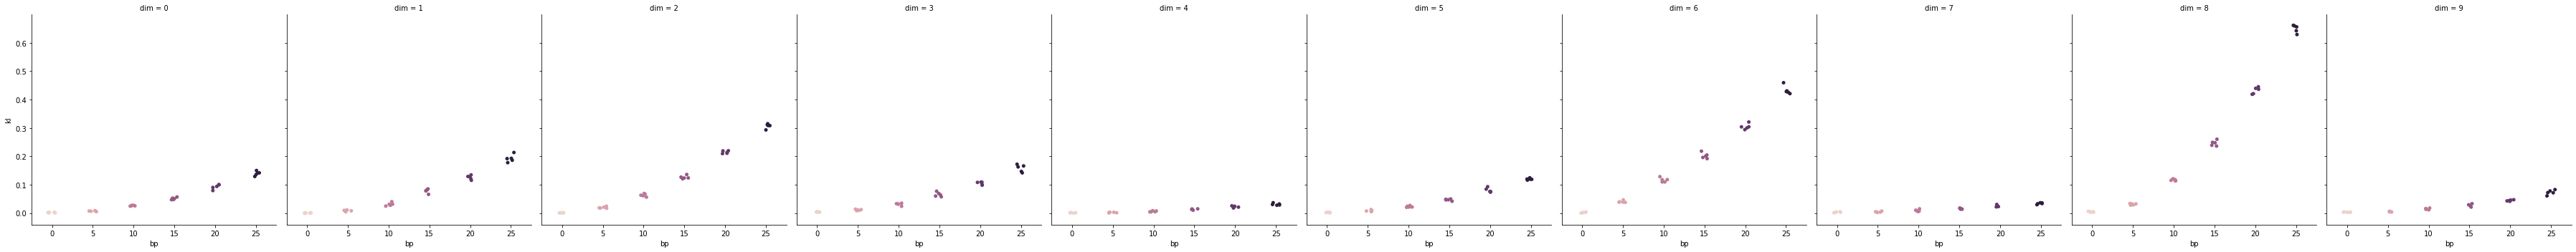

In [146]:
df_kl = pd.DataFrame.from_records(KL, columns=('kl', 'dim', 'bp', 'trial'))
dim_map2 = {d: n for n, d in enumerate(dims[9::-1])}
df_kl['dim'] = df_kl['dim'].map(dim_map2)
# sns.catplot(data=df_kl, x='dim', y='kl', col='bp', legend='full', kind='bar')
sns.catplot(data=df_kl, x='bp', y='kl', col='dim', legend='full', kind='strip', palette=sns.cubehelix_palette(n_colors=6))
# sns.relplot(data=df_kl, x='bp', y='kl', col='dim', legend='full', kind='line')

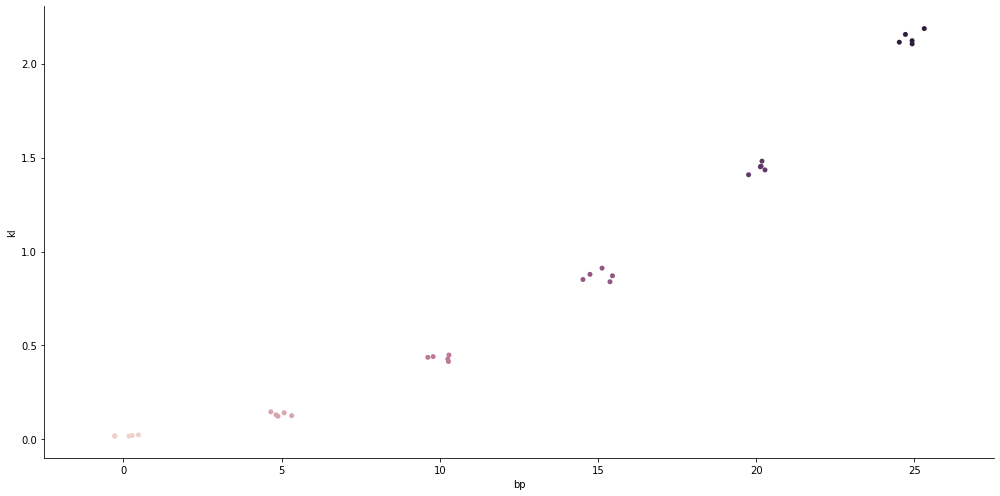

In [147]:
sns.catplot(data=df_kl.groupby(['bp', 'trial']).sum().reset_index(), x='bp', y='kl', aspect=2, height=7, kind='strip', palette=sns.cubehelix_palette(n_colors=6))

In [256]:
N = 100000

XX = []
YY = []
BB = []
DD = []
TT = []

KL = []

for trial in [1, 2]:
    for bad_percent in [0, 5, 10, 15, 20, 25]:
        print(bad_percent)
        bad_data = upscale_srs_dlq(credit, bad_percent/100)
        df_bad_latent, df_bad_syn = synth.encode(bad_data) 
        b_mean, b_stddev = df_bad_latent.loc[:,[f'm_{d}' for d in dims]].rename(columns=lambda x: int(x[2:])), df_bad_latent.loc[:,[f's_{d}' for d in dims]].rename(columns=lambda x: int(x[2:]))

        for n, dim in enumerate(dims[:10]):
            print(n, end='-')
            m, v = mean[dim].to_numpy()[:N], stddev[dim].to_numpy()[:N]**2
            b_m, b_v = b_mean[dim].to_numpy()[:N], b_stddev[dim].to_numpy()[:N]**2

            X = np.arange(-4, 4, 0.01)
            Y = np.array([density(x, m, v)/N for x in X])
            Y2 = np.array([density(x, b_m, b_v)/N for x in X])
            G = [density(x, 0, 1)/1.0 for x in X]

            XX.extend(X.tolist())
            YY.extend((Y2-Y).tolist())
            BB.extend([bad_percent for _ in X])
            DD.extend([dim for _ in X])
            TT.extend([trial for _ in X])

            KL.append((np.sum(Y * np.log(Y/Y2)), dim, bad_percent, trial))

0
0-1-2-3-4-5-6-7-8-9-5
0-1-2-3-4-5-6-7-8-9-10
0-1-2-3-4-5-6-7-8-9-15
0-1-2-3-4-5-6-7-8-9-20
0-1-2-3-4-5-6-7-8-9-25
0-1-2-3-4-5-6-7-8-9-0
0-1-2-3-4-5-6-7-8-9-5
0-1-2-3-4-5-6-7-8-9-10
0-1-2-3-4-5-6-7-8-9-15
0-1-2-3-4-5-6-7-8-9-20
0-1-2-3-4-5-6-7-8-9-25
0-1-2-3-4-5-6-7-8-9-

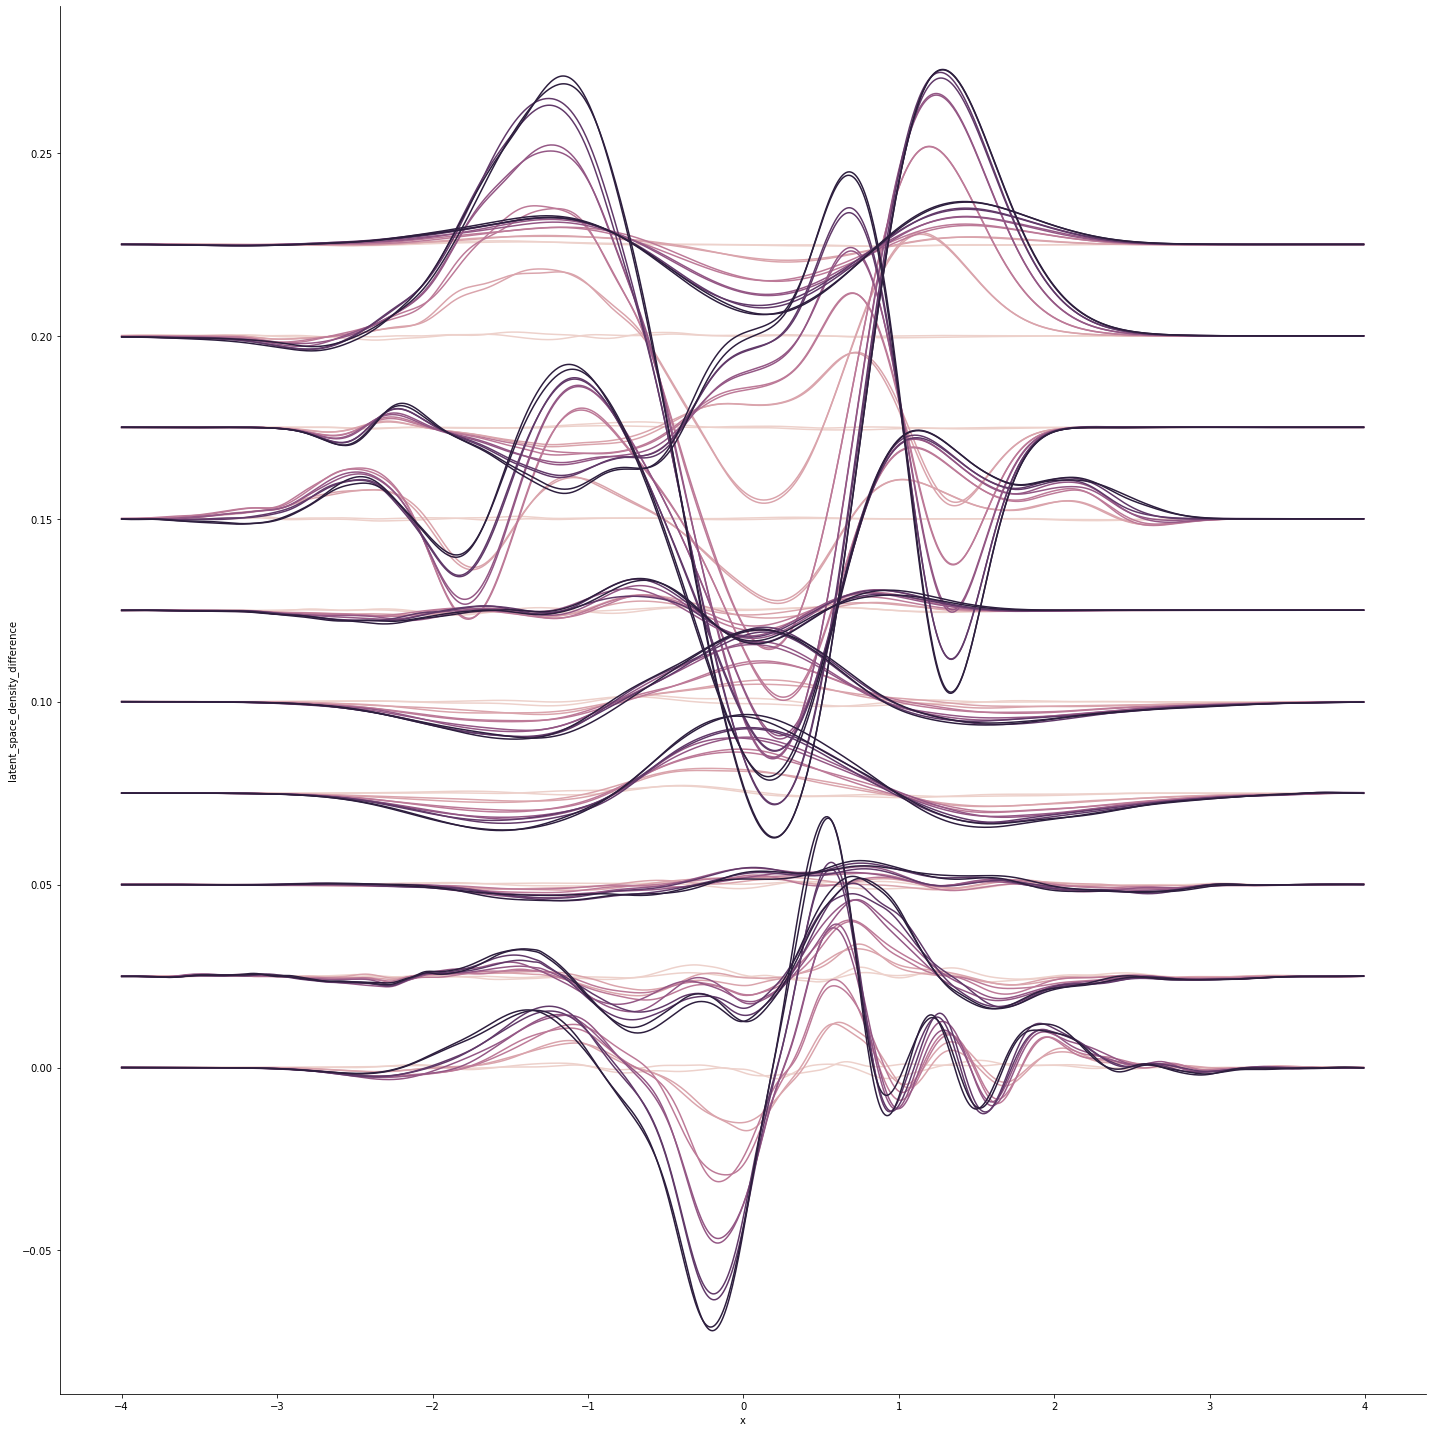

In [259]:
dim_map = {d: n for n, d in enumerate(dims[:10])}

df = pd.DataFrame(dict(x=XX, latent_space_density_difference=(np.array(YY)+np.array([dim_map[d] for d in DD])/40.).tolist(), d=[dim_map[d] for d in DD], b=BB, t=[f'{t}_{d}' for t,d in zip(TT,DD)]))

sns.relplot(data=df, x='x', y='latent_space_density_difference', hue='b', kind='line', aspect=1, legend=False, height=20, style='t', dashes=False)

In [197]:
bad_data = corrupt_data(credit, 20/100, shuffle=False)
df_bad_latent, df_bad_syn = synth.encode(bad_data) 
b_mean = df_bad_latent.loc[:,[f'm_{d}' for d in dims[:10]]].rename(columns=lambda x: dim_map[int(x[2:])])
b_stddev = df_bad_latent.loc[:,[f's_{d}' for d in dims[:10]]].rename(columns=lambda x: dim_map[int(x[2:])])
b_z = df_bad_latent.loc[:,[f'l_{d}' for d in dims[:10]]].rename(columns=lambda x: dim_map[int(x[2:])])

mean = df_latent.loc[:,[f'm_{d}' for d in dims[:10]]].rename(columns=lambda x: dim_map[int(x[2:])])
stddev = df_latent.loc[:,[f's_{d}' for d in dims[:10]]].rename(columns=lambda x: dim_map[int(x[2:])])

In [230]:
P = []
for n in range(1200):
    record = [n, 0 if n < 962 else 1]
    for dim in range(10):
        x = b_mean.iloc[n*100][dim]
        m, v = mean[dim].to_numpy()[:], stddev[dim].to_numpy()[:]**2
        b_m, b_v = b_mean[dim].to_numpy()[:], b_stddev[dim].to_numpy()[:]**2
        record.append(density(x, b_m, b_v) - density(x, m, v))
    P.append(record)

    

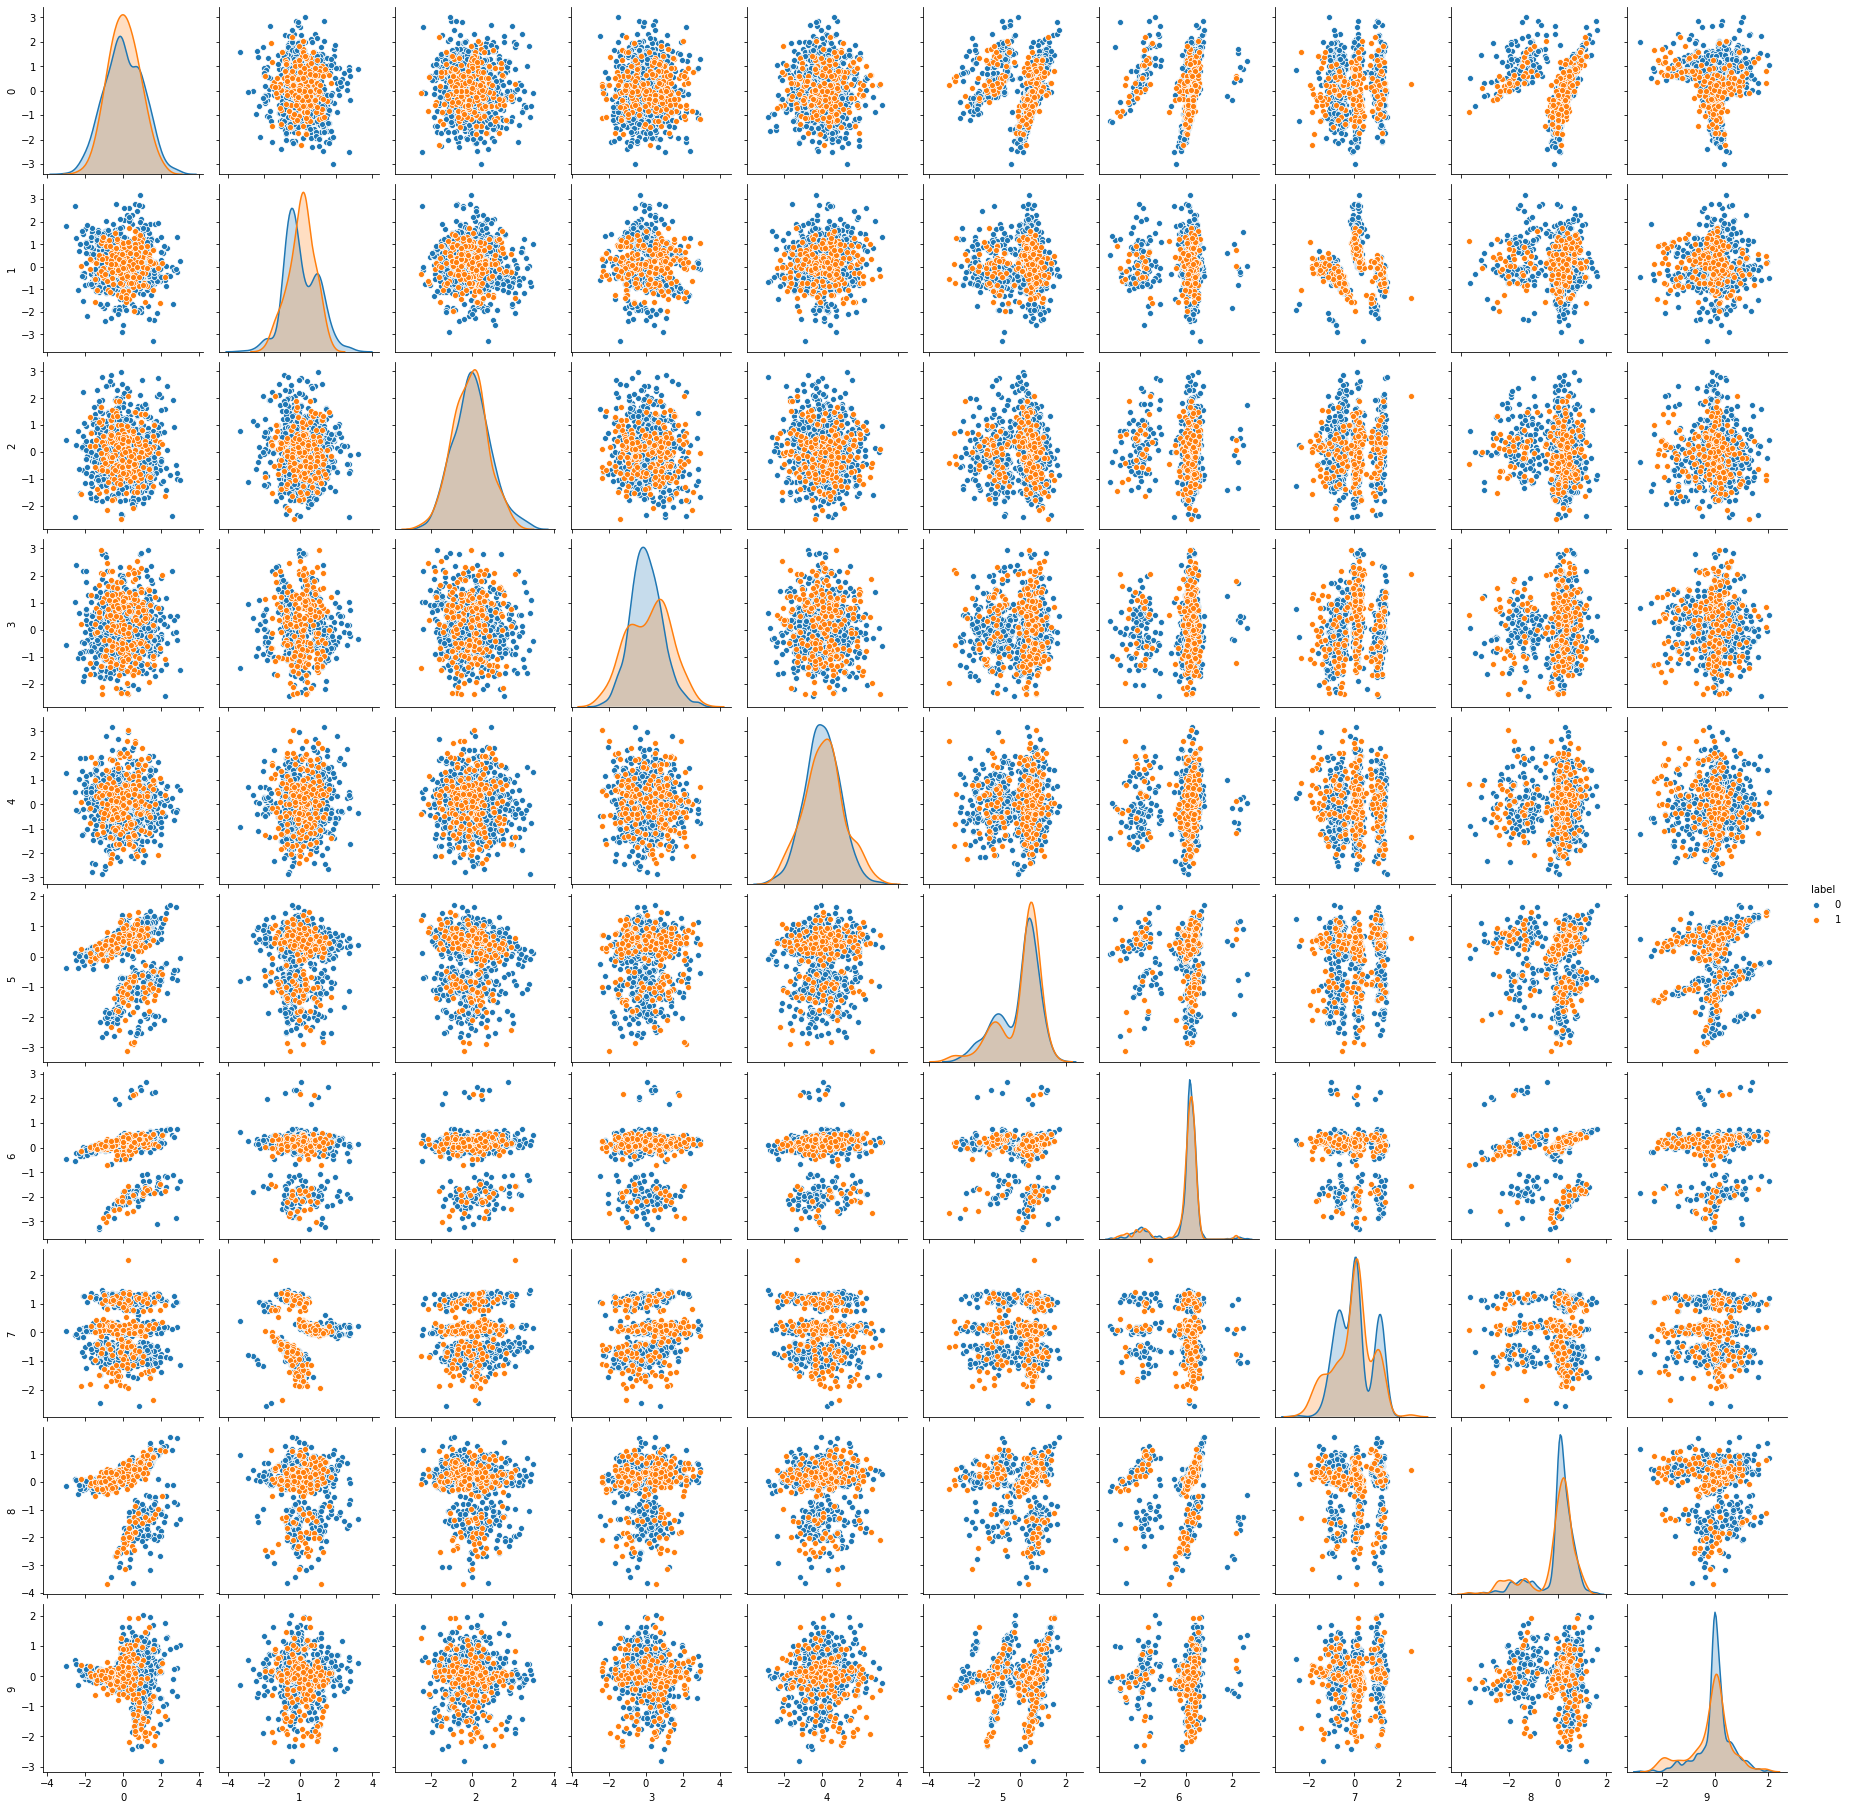

In [246]:
ddf = b_mean.copy()
ddf['label'] = (ddf.index > 0.8 * len(ddf)).astype(np.int32)

sns.pairplot(data=ddf.sample(1000), vars=list(range(10)), hue='label')

96000.0